In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import sys
flopypth = os.path.join('..', '..', '..', 'flopy')
if flopypth not in sys.path:
    sys.path.append(flopypth)
import flopy.modflow as mf
import flopy.mt3d as mt
import flopy.seawat as swt
import flopy.utils as fu

In [2]:
name = 'island'
mf_model = mf.Modflow(modelname = name)

In [3]:
L = 1000.
nlay = 20
nrow = 1
ncol = 100
delr = L / ncol 
H = 20.
delz = H / nlay
top = np.ones((1, ncol)) * delz / 2.
top[0, 10:-10] += delz / 2.
botm = np.linspace(-delz / 2., -H + delz / 2., nlay)
perlen = 7300
dis = mf.ModflowDis(mf_model, nlay, nrow, ncol, delr = delr, delc = 1, 
                    top = top, botm = botm, laycbd = 0, perlen = perlen, 
                    nstp = 730, steady = False)

In [4]:
ibound = np.ones((nlay, nrow, ncol))
ibound[0, 0, :10] = -1
ibound[0, 0, 90:] = -1
bas = mf.ModflowBas(mf_model, ibound = ibound, strt = 0.0)

In [5]:
lpf = mf.ModflowLpf(mf_model, hk = 100.0)

In [6]:
rech = np.zeros((nrow, ncol))
rech[0, (ibound[0, 0, :] == 1)] = 2e-3
rch = mf.ModflowRch(mf_model, rech = rech)

In [7]:
pcg = mf.ModflowPcg(mf_model)
oc = mf.ModflowOc(mf_model) 
mf_model.write_input()
#mf_model.run_model2()

In [8]:
mt_model = mt.Mt3dms(name, 'nam_mt3dms', mf_model)

In [9]:
adv = mt.Mt3dAdv(mt_model, mixelm = 0, percel = 1.)

In [10]:
sconc_1 = np.ones([nlay, nrow, ncol]) * 35.7
timprs = np.arange(1, perlen, 100)
btn = mt.Mt3dBtn(mt_model, ncomp=1, sconc=sconc_1, prsity = 0.25, timprs = timprs)

In [11]:
dsp = mt.Mt3dDsp(mt_model, al=0.1, dmcoef=5e-10*3600.*24.)

In [12]:
gcg = mt.Mt3dGcg(mt_model, cclose = 1e-8)

In [13]:
crch = {0: 0.001}
sp_data = []
for c in range(10):
    dd = np.array([0, 0, c, 0, 1])
    sp_data.append(dd)
for c in range(90, 100):
    dd = np.array([0, 0, c, 0, 1])
    sp_data.append(dd)
stress_period_data = {0:sp_data}
ssm = mt.Mt3dSsm(mt_model, crch=crch, stress_period_data=stress_period_data)

mt_model.write_input()


In [17]:
swt_model = swt.Seawat(name, 'nam_swt', mf_model, mt_model, exe_name='swtv4') # Coupled to modflow model mf and mt3dms model mt
vdf = swt.SeawatVdf(swt_model, firstdt = 0.1, denseslp = .7)
swt_model.write_input()

In [20]:
swt_model.run_model(silent=True)

[False, []]

<matplotlib.contour.QuadContourSet instance at 0x108a6ccb0>

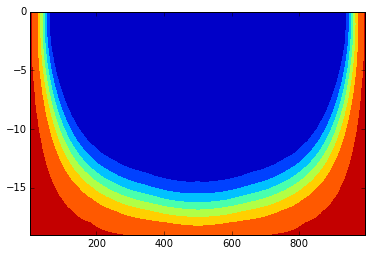

In [19]:
conc = fu.UcnFile('MT3D001.UCN')
c = conc.get_data(totim = 7300)

y, x, z = dis.get_node_coordinates()
X, Z = np.meshgrid(x, z[:, 0, 0])
plt.contourf(X, Z, c[:, 0, :])